### Problem Statement
#### Build a recommender system by using cosine simillarties score.

In [24]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
df = pd.read_csv('book.csv',encoding='latin-1')

df.head()

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6


## Data Exploration

In [26]:
df.shape

(10000, 4)

In [27]:
df.rename(columns={'User.ID':'id','Book.Title':'title','Book.Rating':'rating'},inplace=True)

In [28]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [29]:
df.head()

,id,title,rating
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [8]:
# number of unique users in the dataset

len(df.ID.unique())

2182

In [11]:
# number of unique Books
len(df.Book_Title.unique())

9659

In [30]:
df[df.duplicated()]

,id,title,rating
5051,2152,Le nouveau soleil de Teur,7
7439,3757,The Magician's Tale,7


#### Let's create a ratings dataframe with average rating and number of ratings

In [32]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Dr Mommy (From Here To Maternity) (Silhouette Desire, 1269)                                                           10.0
The Piano Man's Daughter                                                                                              10.0
Private Screening                                                                                                     10.0
The Pilates Body: The Ultimate At-Home Guide to Strengthening, Lengthening, and Toning Your Body--Without Machines    10.0
Desert Solitaire                                                                                                      10.0
Name: rating, dtype: float64

In [33]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Fahrenheit 451                                     5
Ender's Game (Ender Wiggins Saga (Paperback))      4
Stardust                                           4
Vanished                                           4
Charlie and the Chocolate Factory                  4
The Subtle Knife (His Dark Materials, Book 2)      4
The Amber Spyglass (His Dark Materials, Book 3)    4
The Golden Compass (His Dark Materials, Book 1)    3
Pet Sematary                                       3
My Side of the Mountain                            3
Name: rating, dtype: int64

In [35]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0


In [36]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1


## Data Visualization

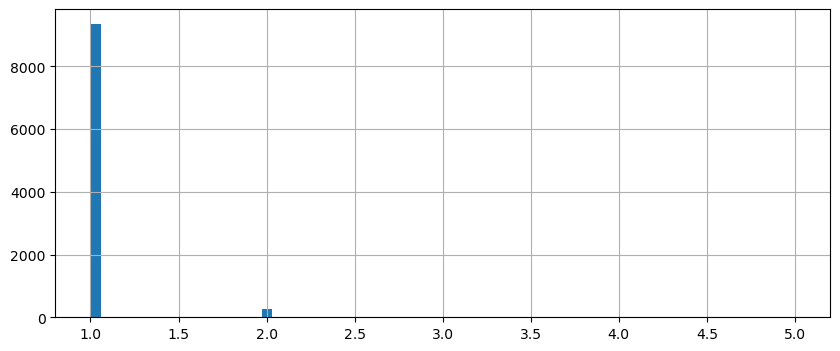

In [37]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)
plt.show()

### Observation: Maximum Number of Books are Rated only Once


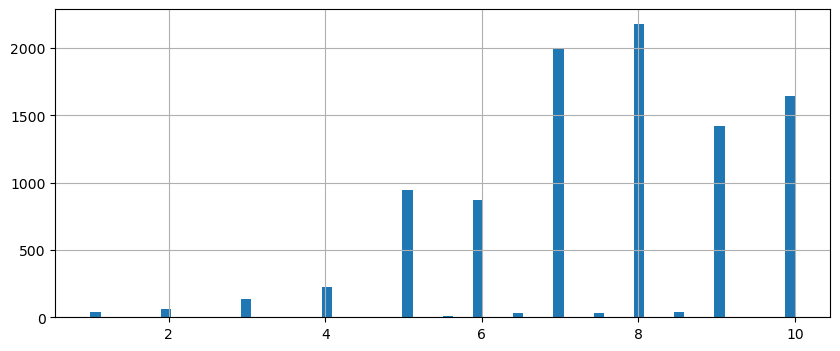

In [38]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.show()

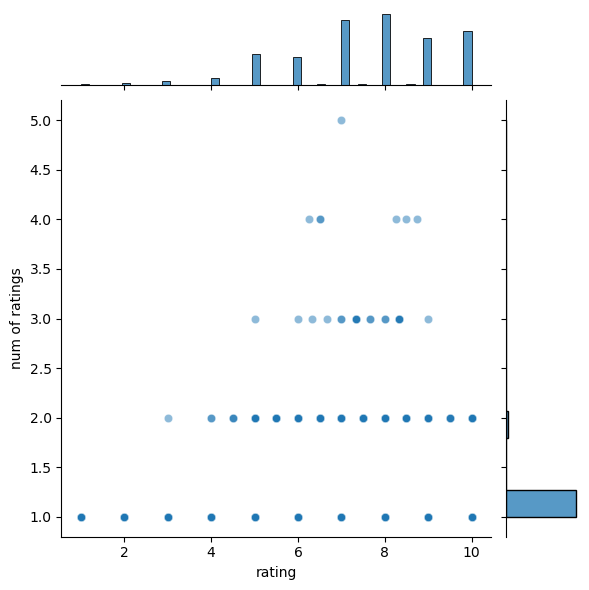

In [40]:
import seaborn as sns
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.show()

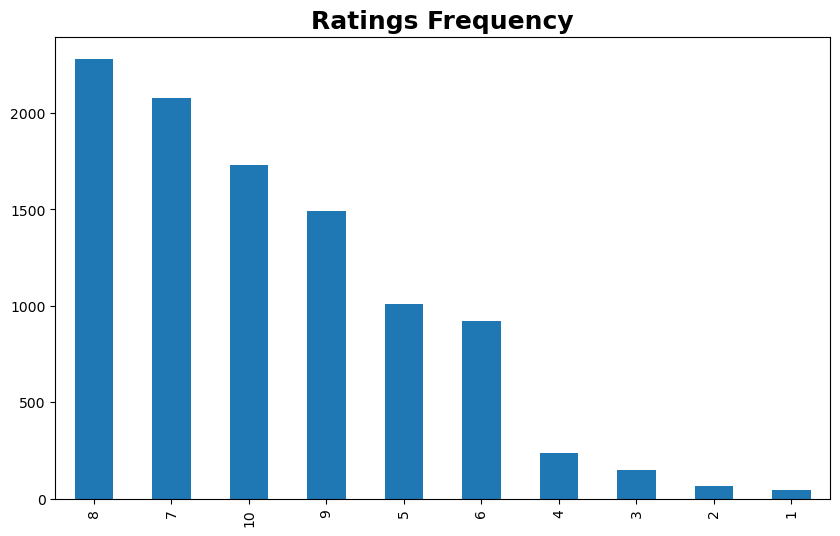

In [42]:
plt.figure(figsize=(10,6))
df['rating'].value_counts().plot(kind='bar')
plt.title('Ratings Frequency',  fontsize = 18, fontweight = 'bold')
plt.show()

#### Observation : Most Frequent Ratings by Users are: 8,7 and 10

In [44]:
top_books = df['title'].value_counts().head(10)
top_books.index

Index(['Fahrenheit 451', 'Charlie and the Chocolate Factory',
       'The Subtle Knife (His Dark Materials, Book 2)', 'Vanished',
       'Ender's Game (Ender Wiggins Saga (Paperback))', 'Stardust',
       'The Amber Spyglass (His Dark Materials, Book 3)', 'Life Is Elsewhere',
       'The Golden Compass (His Dark Materials, Book 1)',
       'The Hitchhiker's Guide to the Galaxy'],
      dtype='object')

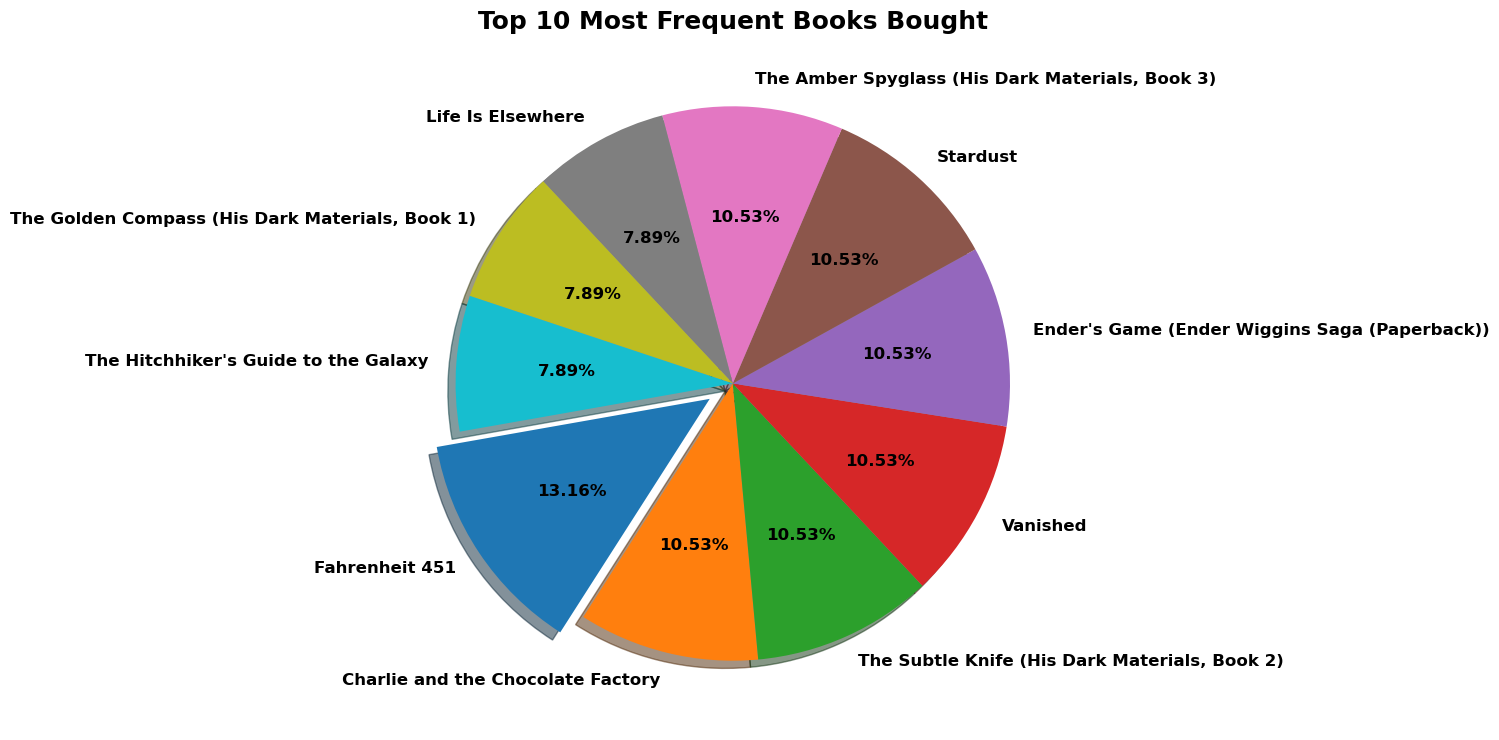

In [45]:
plt.figure(figsize = (16,9))
plt.pie(top_books,
       labels=top_books.index,
       explode = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                   'color':'black'})
#plt.legend(loc= 'best')
plt.title("Top 10 Most Frequent Books Bought", fontsize = 18, fontweight = 'bold')
plt.show()

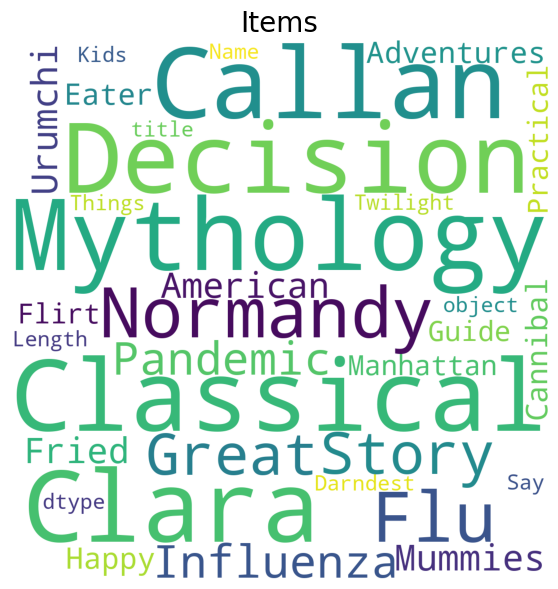

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (7,7)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(df.title))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()

### Data Pre-Processing

In [49]:
# Renaming the columns name
df.rename({'Unnamed: 0':'index','User.ID':'user_id','Book.Title':'title','Book.Rating':'rating'}, axis= 1, inplace =True)
df.set_index('index', inplace=True)
df

,user_id,title,rating
index,,,
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6
...,...,...,...
9996,162121,American Fried: Adventures of a Happy Eater.,7
9997,162121,Cannibal In Manhattan,9
9998,162121,How to Flirt: A Practical Guide,7


### Collaborative Book Recommendation System

In [50]:
user_books_df = df.pivot_table(index='user_id',columns = 'title', values = 'rating').fillna(0)
user_books_df

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [51]:
# Calculating Cosine Similarity between Users

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [52]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Fahrenheit 451,7.000000,5
Ender's Game (Ender Wiggins Saga (Paperback)),6.250000,4
Stardust,8.500000,4
Vanished,6.500000,4
Charlie and the Chocolate Factory,6.500000,4
"The Subtle Knife (His Dark Materials, Book 2)",8.750000,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.250000,4
"The Golden Compass (His Dark Materials, Book 1)",8.333333,3
Pet Sematary,7.666667,3


In [53]:
stardust_user_ratings = user_books_df['Stardust']
fahrenheit_user_rating = user_books_df['Fahrenheit 451']
fahrenheit_user_rating.head()

user_id
8     0.0
9     0.0
10    0.0
12    0.0
14    0.0
Name: Fahrenheit 451, dtype: float64

+ We can then use corrwith() method to get correlations between two pandas series:

In [54]:
similar_to_fahrenheit = user_books_df.corrwith(fahrenheit_user_rating)
similar_to_stardust = user_books_df.corrwith(stardust_user_ratings)

In [55]:
corr_fahrenheit = pd.DataFrame(similar_to_fahrenheit,columns=['Correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit.head()

,Correlation
title,
"Jason, Madison &amp",-0.000958
Other Stories;Merril;1985;McClelland &amp,-0.000958
Repairing PC Drives &amp,-0.000958
'48,-0.000958
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958


#### Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of books that are rated only once.

In [56]:
corr_fahrenheit.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Fahrenheit 451,1.000000
The Day I Swapped My Dad for 2 Goldfish,0.596326
The Onion Girl,0.596326
Bloodcurdling Tales of Horror,0.596326
The Ambassador's Women,0.596326
Silent Witness,0.596326
"Dream Country (Sandman, Book 3)",0.596326
Mr. Punch,0.596326
Tap d'escopeta (MÃ­nima de butxaca),0.596326


+ Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [57]:
corr_fahrenheit = corr_fahrenheit.join(ratings['rating'])
corr_fahrenheit.head()

,Correlation,rating
title,,
"Jason, Madison &amp",-0.000958,8.0
Other Stories;Merril;1985;McClelland &amp,-0.000958,6.0
Repairing PC Drives &amp,-0.000958,4.0
'48,-0.000958,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958,8.0


Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

### Recommending Similar Books Using Correlation
#### Based on Ratings
Now let's create a matrix that has the user ids on one axis and the movie title on another axis. Each cell will then consist of the rating the users gave to that Book. Note there will be a lot of NaN values, because most people have not given rating to most of the books

In [58]:
corr_fahrenheit[corr_fahrenheit['rating']>5].sort_values('Correlation',ascending=False).head()

,Correlation,rating
title,,
Fahrenheit 451,1.000000,7.0
The Day I Swapped My Dad for 2 Goldfish,0.596326,9.0
Black Market,0.596326,7.0
"Dream Country (Sandman, Book 3)",0.596326,7.0
Mr. Punch,0.596326,7.0


In [59]:
corr_stardust = pd.DataFrame(similar_to_stardust,columns=['Correlation'])
corr_stardust.dropna(inplace=True)
corr_stardust = corr_stardust.join(ratings['num of ratings'])
corr_stardust[corr_stardust['num of ratings']>4].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Fahrenheit 451,-0.001908,5


### Collaborative Recommender System Using Cosine Similarity.

In [60]:
user_books_df.head()

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
user_sim = 1 - pairwise_distances(user_books_df.values, metric = 'cosine')
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [62]:
# Store the results in a dataframe
user_sim_df = pd.DataFrame(user_sim)
user_sim_df

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
user_sim_df.iloc[:5,:5]

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [64]:
np.fill_diagonal(user_sim, 0)
user_sim_df.iloc[0:5,0:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [65]:
# Set the index and column name to user Ids
user_sim_df.index = list(user_books_df.index)
user_sim_df.columns = list(user_books_df.index)
user_sim_df

,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
user_id_eight = user_sim_df.sort_values([9], ascending=False).head(100)
user_id_eight[9]

8         0.0
161755    0.0
161744    0.0
161749    0.0
161750    0.0
         ... 
161441    0.0
161436    0.0
161434    0.0
161431    0.0
161423    0.0
Name: 9, Length: 100, dtype: float64

In [68]:
df[(df['user_id']==8) | (df['user_id']==14)]

,user_id,title,rating
index,,,
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7
2410,14,COPS,5
2411,14,A Cold Heart: An Alex Delaware Novel,5


In [69]:
# Most Similar Users
user_sim_df.idxmax(axis=1)

8              8
9              8
10             8
12             8
14             8
           ...  
278846         8
278849         8
278851    278202
278852         8
278854         8
Length: 2182, dtype: int64

### Recommnedation Based on Cosine Similarity

In [72]:
def give_reco(customer_id):
    tem = list(user_sim_df.sort_values([customer_id],ascending=False).head(100).index)
    #print('similar customer ids:',tem)
    movie_list=[]
    for i in tem:
        movie_list=movie_list+list(df[df['user_id']==i]['title'])
    #print('Common movies within customer',movie_list)
    return set(movie_list)-set(df[df['user_id']==customer_id]['title'])

In [73]:
give_reco(14)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci

In [74]:
give_reco(8)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci